In [1]:
import os
import model_ed_tcn as md
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
def load_data(datapath, numOfSubjects):

    ext = '.npy'
    
    x_data = []
    y_data = []
    
    for index in range(numOfSubjects):
        x = np.load(os.path.join(datapath, 'x_data' + str(index) + ext))
        y = np.load(os.path.join(datapath, 'y_data' + str(index) + ext))
        
        x_data.append(x)
        y_data.append(y)
    
    

        
        
    return x_data, y_data

In [3]:
x_data, y_data = load_data('../data256', 36)

In [4]:
model_obj = md.ED_TCN_fmap_fuse(
    n_classes=6,
    input_length=256,
    early_fuse_cnn_channels=128,
    tcn_encoder_channels=[128]*4,
    tcn_decoder_channels=[128]*4,
    tcn_encoder_maxpool_size=[2]*4,
    tcn_decoder_upsample_size=[2, 2, 2, 2],
    early_fuse_conv_kernel_size=3,
    before_encode_pool_size=2,
    tcn_kernel_size=5,
    tcn_drop_rate=0.3,
    use_spatial_drop=True,
    drop_rate_before_midfc=0.3,
    drop_rate_before_fcclassifier=0.3,
    use_init_batch_norm=True,
)

In [5]:
def create_model(learning_rate=0.001):
    global model_obj
    
    model = model_obj.create_model()
    
    import tensorflow
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [7]:
model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 3)            0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 256, 3)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 3)            12        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 128)          1280      
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 128)          512       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 256, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 128)          0   

In [8]:
train_results = []
num_of_subjects = 36
learning_rate = 1e-3
batch_size = 32

count = 0
sum = 0

print('Train with learning rate ' + str(learning_rate) + ' and batch size ' + str(batch_size))


x_valid_list = x_data[0:12]
y_valid_list = y_data[0:12]

x_train_list = x_data[12:36]
y_train_list = y_data[12:36]


x_valid = np.concatenate(tuple(x_valid_list))
y_valid = np.concatenate(tuple(y_valid_list))
x_train = np.concatenate(tuple(x_train_list))
y_train = np.concatenate(tuple(y_train_list))


model = create_model(learning_rate)

from keras.callbacks import EarlyStopping

my_callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_accuracy:.2f}.h5',
                                       monitor="val_accuracy",
                                       save_best_only=True)
]


H = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), callbacks=my_callbacks, batch_size=batch_size, epochs=20, verbose=1)

best_acc = np.max(H.history['val_accuracy'])
print('Best acc of this valid set ' + str(best_acc))



        

Train with learning rate 0.001 and batch size 32
Train on 2821 samples, validate on 1268 samples
Epoch 1/20
2821/2821 [==============================] - 5s 2ms/step - loss: 0.8349 - accuracy: 0.7122 - val_loss: 2.9884 - val_accuracy: 0.1782
Epoch 2/20
 320/2821 [==>...........................] - ETA: 1s - loss: 0.6577 - accuracy: 0.7563

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


2821/2821 [==============================] - 2s 662us/step - loss: 0.5716 - accuracy: 0.7884 - val_loss: 5.3957 - val_accuracy: 0.0781
Epoch 3/20
2821/2821 [==============================] - 2s 666us/step - loss: 0.5208 - accuracy: 0.8128 - val_loss: 2.8942 - val_accuracy: 0.3628
Epoch 4/20
2821/2821 [==============================] - 2s 658us/step - loss: 0.4407 - accuracy: 0.8380 - val_loss: 1.2097 - val_accuracy: 0.6972
Epoch 5/20
2821/2821 [==============================] - 2s 670us/step - loss: 0.3397 - accuracy: 0.8827 - val_loss: 1.5051 - val_accuracy: 0.7027
Epoch 6/20
2821/2821 [==============================] - 2s 666us/step - loss: 0.3521 - accuracy: 0.8724 - val_loss: 1.1154 - val_accuracy: 0.7744
Epoch 7/20
2821/2821 [==============================] - 2s 668us/step - loss: 0.3269 - accuracy: 0.8901 - val_loss: 0.9624 - val_accuracy: 0.7847
Epoch 8/20
2821/2821 [==============================] - 2s 664us/step - loss: 0.2936 - accuracy: 0.9050 - val_loss: 0.8723 - val_accura

              precision    recall  f1-score   support

     Jogging       0.97      1.00      0.98       418
     Sitting       0.90      0.92      0.91        49
    Standing       1.00      1.00      1.00        51
     Walking       0.99      0.78      0.87       557
    Upstairs       0.75      0.72      0.73       106
  Downstairs       0.42      0.91      0.57        87

   micro avg       0.87      0.87      0.87      1268
   macro avg       0.84      0.89      0.84      1268
weighted avg       0.92      0.87      0.88      1268

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

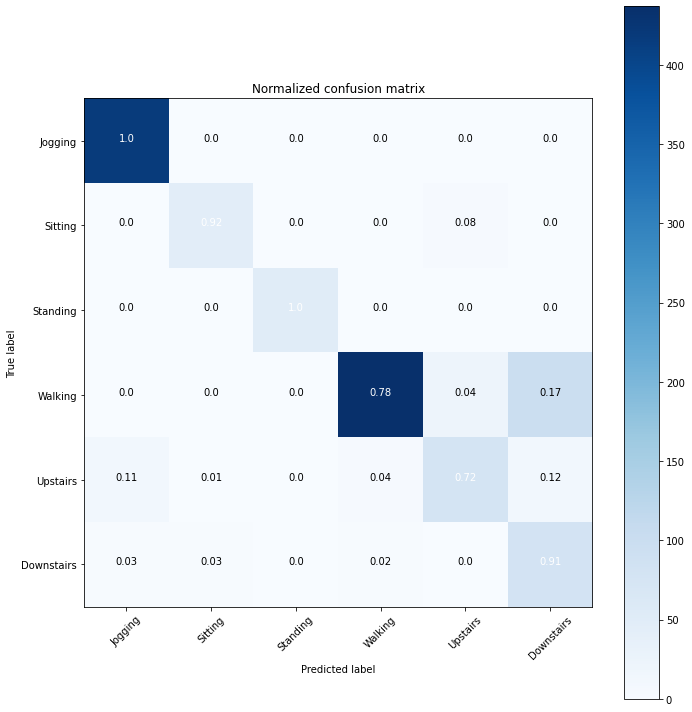

In [15]:
model = keras.models.load_model('model.11-0.87.h5')

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(x_valid)
y_pred = np.argmax(y_pred, axis = 1)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def show_classification_report(y_true, y_pred, digits=4, labels=None, save_path=None):
    """
    :param y_true: 1d array containing y true
    :param y_pred: 1d array containing y pred
    :param digits: number of digits to show
    :param labels: list label names
    :param save_path: path to save report
    """

    # Select only existing labels from y true and y pred
    unique_labels = np.unique(np.array([y_true, y_pred])).astype(np.int)
    labels = labels[unique_labels]

    # show report
    report = classification_report(y_true, y_pred, digits=digits, target_names=labels)
    print(report)

    # save to file
    if save_path is not None:
        with open(save_path, 'w') as f:
            f.write(report)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = np.array(['Jogging',
'Sitting',
'Standing',
'Walking',
'Upstairs',
'Downstairs'
])
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Show classificaiton report
show_classification_report(y_true, y_pred, digits=2, labels=class_names)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize = True,
                      title='Normalized confusion matrix')

plt.show()

In [9]:
f = open('result.txt', 'w')
for e in train_results:
    f.write(str(e))
f.close()

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.8832807570977917